In [1]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from keras.utils.np_utils import to_categorical
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from sklearn.model_selection import train_test_split,KFold, cross_val_score, GridSearchCV
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D,BatchNormalization,Dropout,Conv2D,MaxPool2D

In [2]:
labels = ['NORMAL', 'KNOCKKNEES']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = "X:/miniproject/train"
test = "X:/miniproject/test"
val = "X:/miniproject/val"

In [4]:
train_normal = "X:/miniproject/train/normal"
train_knockknees = "X:/miniproject/train/knockknees"

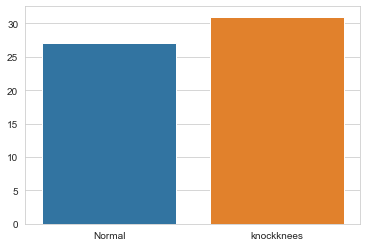

In [5]:
import seaborn as sns
sns.set_style('whitegrid')
sns.barplot(x=['Normal','knockknees'],y=[len(train_normal), len(train_knockknees )])

In [6]:
input_height=128
input_width=128
batch_size=32

In [7]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(train, 
                                                             color_mode='grayscale', 
                                                             image_size=(input_height, input_width), 
                                                             batch_size=batch_size)

test_ds=tf.keras.preprocessing.image_dataset_from_directory(test, 
                                                             color_mode='grayscale', 
                                                             image_size=(input_height, input_width), 
                                                             batch_size=batch_size)

val_ds=tf.keras.preprocessing.image_dataset_from_directory(val, 
                                                             color_mode='grayscale', 
                                                             image_size=(input_height, input_width), 
                                                             batch_size=batch_size)

Found 3185 files belonging to 2 classes.
Found 2616 files belonging to 2 classes.
Found 72 files belonging to 2 classes.


In [8]:
train_ds.class_names

['knockknees', 'normal']

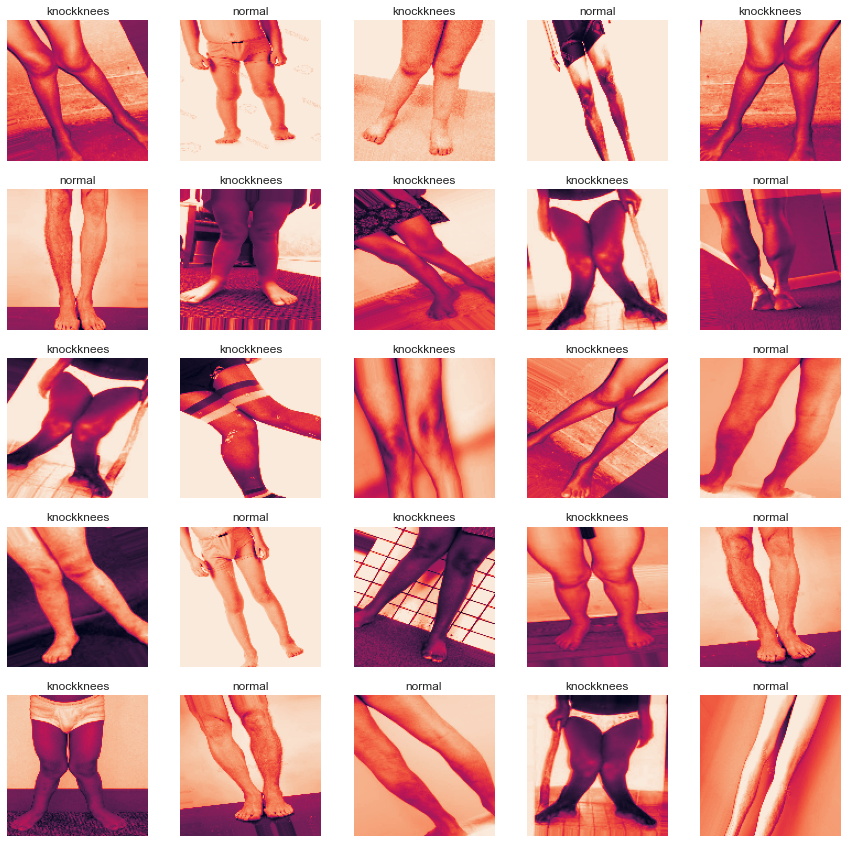

In [9]:
plt.figure(figsize=(15,15))
for images, labels in train_ds.take(1):
    for i in range(25):
        
        plt.subplot(5, 5, i+1)
        plt.imshow(np.squeeze(images[i].numpy().astype('uint8')))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis('off')

In [10]:
training_dir = "X:/miniproject/train"
training_generator = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   shear_range=0.2,
                                   zoom_range=0.2 )
train_generator = training_generator.flow_from_directory(training_dir,target_size=(200,200),batch_size=4,class_mode='binary')

Found 3185 images belonging to 2 classes.


In [11]:
validation_dir = "X:/miniproject/val"
validation_generator = ImageDataGenerator(rescale=1./255)
valid_generator = validation_generator.flow_from_directory(validation_dir,target_size=(200,200),batch_size=4,class_mode='binary')

Found 72 images belonging to 2 classes.


In [12]:
testing_dir = "X:/miniproject/test"
testing_generator = ImageDataGenerator(rescale=1./255)
test_generator = testing_generator.flow_from_directory(testing_dir,target_size=(200,200),batch_size=4,class_mode='binary')

Found 2616 images belonging to 2 classes.


In [13]:
model = Sequential()

model.add(ResNet50(include_top=False,input_tensor=None,input_shape=(224,224,3),pooling='avg',classes=2,weights='imagenet'))
model.add(Flatten())

model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.layers[0].trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,597,953
Trainable params: 6,145
Non-trainable params: 23,591,808
_________________________________________________________________


In [14]:
model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [15]:
red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.7)

In [16]:

history = model.fit_generator(train_generator,
                              validation_data = valid_generator,
                              epochs = 5,
                              verbose = 1,
                              callbacks = [red_lr]
                             )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
797/797 [==============================] - 352s 442ms/step - loss: 0.6298 - accuracy: 0.6622 - val_loss: 0.3935 - val_accuracy: 0.8472
Epoch 2/5
797/797 [==============================] - 249s 312ms/step - loss: 0.5575 - accuracy: 0.7199 - val_loss: 0.3265 - val_accuracy: 0.8611
Epoch 3/5
797/797 [==============================] - 251s 315ms/step - loss: 0.5322 - accuracy: 0.7353 - val_loss: 0.3015 - val_accuracy: 0.8611
Epoch 4/5
797/797 [==============================] - 244s 306ms/step - loss: 0.5355 - accuracy: 0.7338 - val_loss: 0.2845 - val_accuracy: 0.8889
Epoch 5/5
797/797 [==============================] - 252s 316ms/step - loss: 0.5196 - accuracy: 0.7400 - val_loss: 0.2779 - val_accuracy: 0.8889


<Figure size 432x288 with 0 Axes>

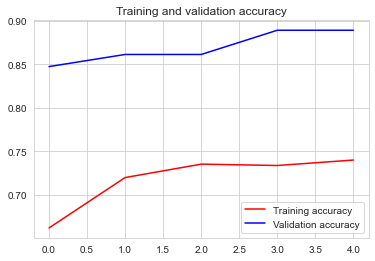

<Figure size 432x288 with 0 Axes>

In [17]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()